This notebook demonstrates use of the Synaptic Physiology dataset to look at synaptic conductances. 



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from aisynphys.database import default_db
import aisynphys.pipeline.multipatch.conductance as conductance_pipeline

In [2]:
db = default_db
session = db.session()

### Analyze conductance for a single synapse first

(we will look at conductances for all synapses later in the notebook)

In [3]:
# syn = db.pair_query(synapse=True, synapse_type='in', session=session)
# example_pair = syn[3]

# inhibitory
example_pair = db.pair_from_ext_id('1614212743.568', '6', '4')

# excitatory w/ failures, crosstalk
# example_pair = db.pair_from_ext_id('1625092356.185', '6', '7')

# example_pair = db.pair_from_ext_id('1596739041.999 1 6')

print(f"Selected {example_pair.synapse.synapse_type} pair {example_pair}")

psc_sign = {'in': -1, 'ex': 1}[example_pair.synapse.synapse_type]

Selected in pair <Pair 1614212743.568 6 4>


Load VC data for this synapse

In [4]:
vc_data = conductance_pipeline.get_raw_vc_data(example_pair, db, session)
if vc_data['error'] is not None:
    print(f"Error loading data: {vc_data['error']}")
    adj_holding = None
    amps = None
else:
    adj_holding = vc_data['adj_baseline']
    amps = vc_data['pr_amps']

Plot the raw data we are working with 

Text(0.5, 0, 'Time (ms)')

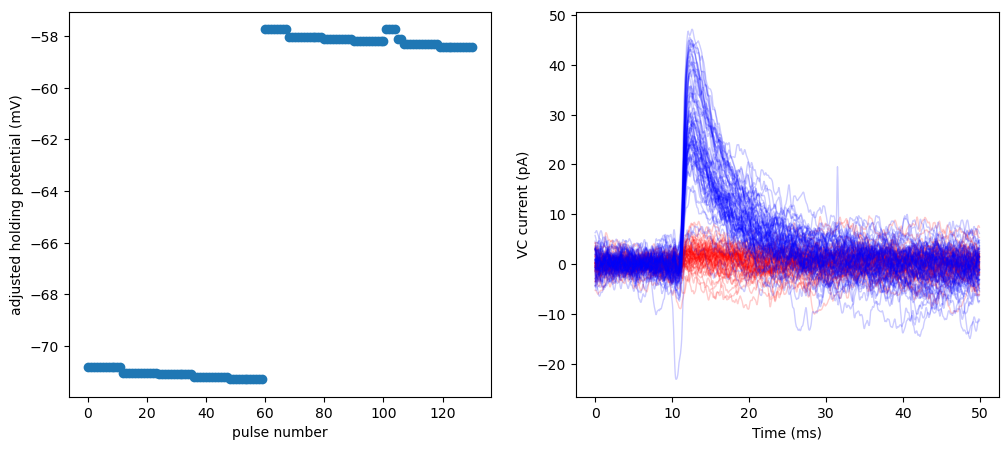

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].scatter(np.arange(len(adj_holding)), adj_holding * 1e3)
ax[0].set_ylabel('adjusted holding potential (mV)')
ax[0].set_xlabel('pulse number')

from neuroanalysis.filter import bessel_filter
prs = vc_data['pulse_responses']
for pr in prs:
    ts = bessel_filter(pr.post_tseries.copy(), cutoff=2e3)
    ts.t0 = 0
    baseline = ts.time_slice(0, 10e-3).data.mean()
    holding = pr.recording.patch_clamp_recording.access_adj_baseline_potential
    amp = pr.pulse_response_fit.fit_amp
    color = 'red' if holding < -60e-3 else 'blue'
    ax[1].plot(ts.time_values * 1e3, (ts.data - baseline) * 1e12, alpha=0.2, color=color, linewidth=1)
ax[1].set_ylabel('VC current (pA)')
ax[1].set_xlabel('Time (ms)')

### Estimate the conductance and reversal potential for selected synapse

Estimated conductance: 2.19+/-0.11 nS
Estimated reversal: -71.87+/-0.49 mV
Fit R^2: 0.7692721044203041


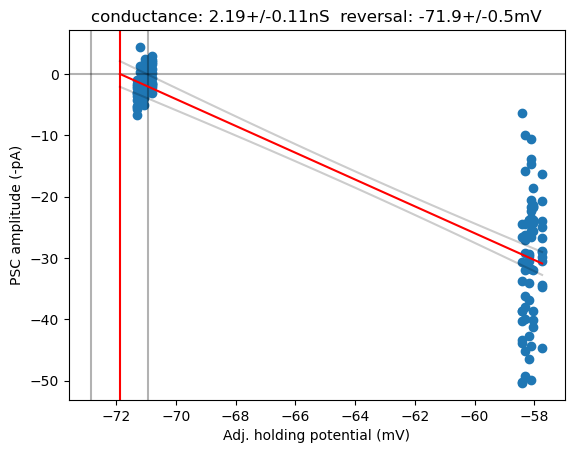

In [6]:

# plot PSC amplitudes first
fig, ax = plt.subplots()
ax.scatter(adj_holding * 1e3, amps * -1e12)
ax.set_xlabel('Adj. holding potential (mV)')
ax.set_ylabel('PSC amplitude (-pA)')

# calculate conductance and reversal potential
syn_type = example_pair.synapse.synapse_type
fixed_reversal = None if syn_type == 'in' else 10e-3
conductance, reversal, r2 = conductance_pipeline.calculate_conductance(amps, adj_holding, syn_type=syn_type, fixed_reversal=fixed_reversal)

print(f"Estimated conductance: {conductance*1e9:0.2f} nS")
print(f"Estimated reversal: {reversal*1e3:0.2f} mV")
print(f"Fit R^2: {r2}")

# plot conductance and reversal with CIs
ci_x = np.linspace(min(reversal.n, adj_holding.min()), max(reversal.n, adj_holding.max()), 100)
ci_y = conductance_pipeline.ipsc_amp_fn(ci_x, conductance, reversal)
nom = np.array([x.n for x in ci_y])
std = np.array([x.s for x in ci_y])
upper_ci = nom + 1.96 * std
lower_ci = nom - 1.96 * std

ax.set_title(f'conductance: {conductance*1e9}nS  reversal: {reversal*1e3}mV')
ax.axvline(reversal.n * 1e3, color='red')
ax.axvline((reversal.n + 1.96 * reversal.s) * 1e3, color=(0, 0, 0, 0.3))
ax.axvline((reversal.n - 1.96 * reversal.s) * 1e3, color=(0, 0, 0, 0.3))
ax.axhline(0, color=(0, 0, 0, 0.3))

ax.plot(ci_x * 1e3, nom * -1e12, color='red')
ax.plot(ci_x * 1e3, upper_ci * -1e12, color=(0, 0, 0, 0.2))
ax.plot(ci_x * 1e3, lower_ci * -1e12, color=(0, 0, 0, 0.2))


### Load conductance results from all synapses (where available)

Note that excitatory reversal potentials are artificially pinned to 14 mV (this is 0 mV after subtracting junction potential, the expected reversal potential for NMDA/AMPA receptors). This is because we do not test synapses over a wide enough range of holding potentials to accurately determine excitatory reversal.

In [7]:
import pandas
cond_df = db.query(
    db.Conductance.effective_conductance, 
    db.Conductance.reversal_potential,
    db.Conductance.meta,
    db.Synapse.synapse_type,
    db.Synapse.psc_rise_time,
    db.Synapse.psc_decay_tau,
).join(db.Synapse).dataframe()

Text(0.5, 1.0, 'Excitatory and inhibitory reversal potentials')

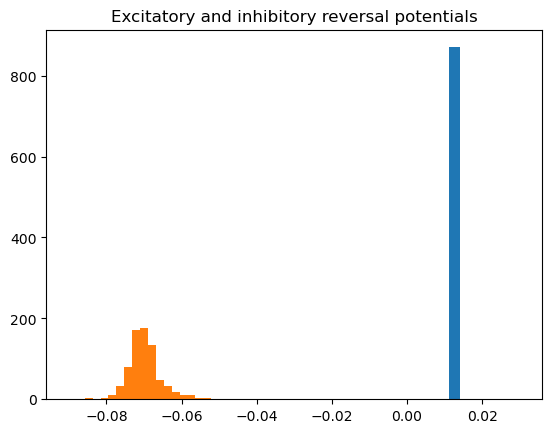

In [8]:
fig, ax = plt.subplots()
ax.hist(cond_df[cond_df['synapse.synapse_type']=='ex']['conductance.reversal_potential'], bins=np.linspace(-30e-3, 30e-3, 20))
ax.hist(cond_df[cond_df['synapse.synapse_type']=='in']['conductance.reversal_potential'], bins=np.linspace(-90e-3, -50e-3, 20))
ax.set_title("Excitatory and inhibitory reversal potentials")


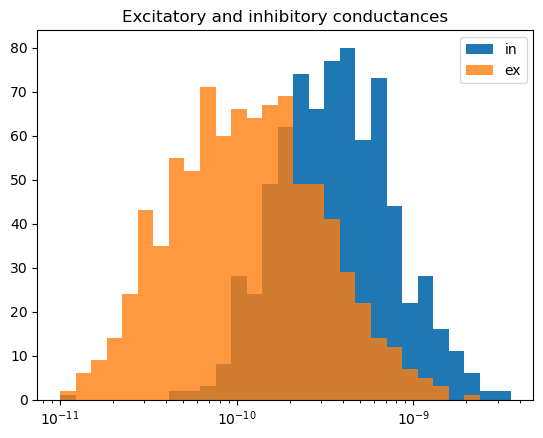

In [9]:
fig, ax = plt.subplots()
bins = 1e-11 * 1.8**np.linspace(0, 10, 30)
ax.hist(cond_df[cond_df['synapse.synapse_type']=='in']['conductance.effective_conductance'], bins=bins, label='in')
ax.hist(cond_df[cond_df['synapse.synapse_type']=='ex']['conductance.effective_conductance'], bins=bins, alpha=0.8, label='ex')
ax.set_title("Excitatory and inhibitory conductances")
ax.set_xscale('log')
ax.legend()


### Calculate expected charge transfer at threshold

In [10]:
from neuroanalysis.fitting import Psp

# calculate charge transfer at this potential
test_voltage = -50e-3

x = np.linspace(0, 50e-3, 1000)
dt = x[1] - x[0]
auc = []
for k,row in cond_df.iterrows():
    dv = test_voltage - row['conductance.reversal_potential']
    amp = dv * row['conductance.effective_conductance']
    current = Psp.psp_func(
        x, 
        xoffset=0, 
        yoffset=0, 
        rise_time=row['synapse.psc_rise_time'],
        decay_tau=row['synapse.psc_decay_tau'],
        amp=amp,
        rise_power=2,
    )
    charge = current.sum() * dt
    auc.append(charge)

cond_df['charge_transfer'] = auc

/home/luke/miniconda3/envs/aisynphys/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Text(0, 0.5, 'excitatory')

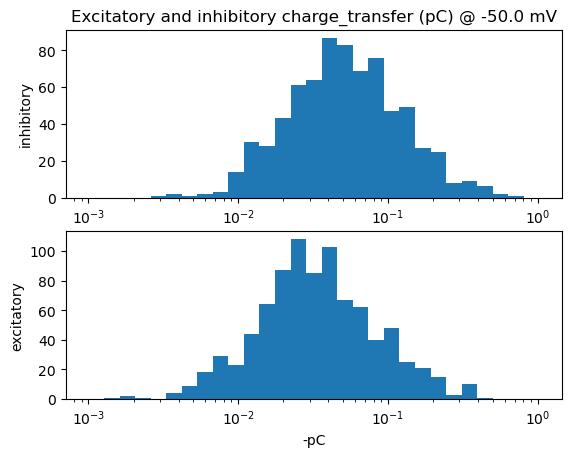

In [11]:
yscale = 1e12
yunits = 'pC'

fig, ax = plt.subplots(2, 1)
bins = 1e-3 * 2**np.linspace(0, 10, 30)
# bins = np.linspace(cond_df['charge_transfer'].min()*yscale, cond_df['charge_transfer'].max()*yscale, 100)
ax[0].hist(cond_df[cond_df['synapse.synapse_type']=='in']['charge_transfer']*yscale, bins=bins, label='in')
ax[1].hist(-cond_df[cond_df['synapse.synapse_type']=='ex']['charge_transfer']*yscale, bins=bins, label='ex')
ax[0].set_title(f"Excitatory and inhibitory charge_transfer ({yunits}) @ {test_voltage * 1000} mV")
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].set_xlabel(yunits)
ax[1].set_xlabel(f'-{yunits}')
ax[0].set_ylabel('inhibitory')
ax[1].set_ylabel(f'excitatory')



### Compare reversal and conductance of pvalb, sst, and vip 

In [12]:
pairs = db.pair_query(
    experiment_type='standard_multipatch',   # filter: just multipatch experiments
    species='mouse',                         # filter: only mouse data
    synapse=True,                            # filter: only cell pairs connected by synapse
    synapse_type='in',                       # inhibitory synapses only
    preload=['synapse', 'cell'],             # include extra tables that contain synapse AND cell properties
).dataframe()
pairs = pairs[pairs['pre_cell.cre_type'].isin(['pvalb', 'sst', 'vip'])]

<Axes: xlabel='conductance.reversal_potential', ylabel='Count'>

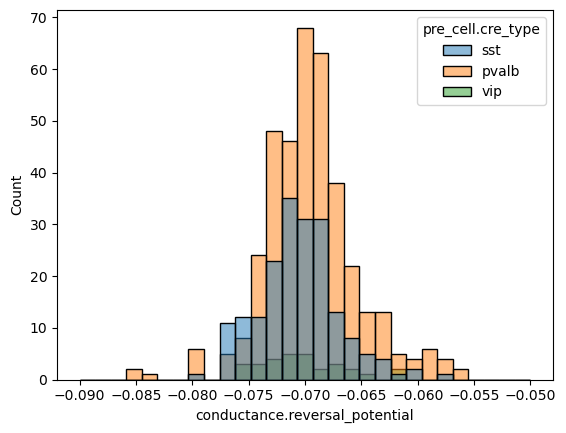

In [13]:

seaborn.histplot(data=pairs, x='conductance.reversal_potential', hue='pre_cell.cre_type', bins=np.linspace(-90e-3, -50e-3, 30))

/home/luke/miniconda3/envs/aisynphys/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='conductance.effective_conductance', ylabel='Count'>

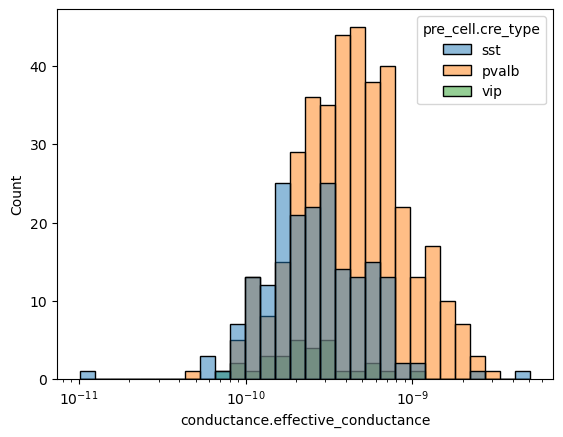

In [14]:

seaborn.histplot(data=pairs, x='conductance.effective_conductance', hue='pre_cell.cre_type', bins=30, log_scale=True)